```
Muris Saab
ADS 509 - Assignment 6.1
University of San Diego
```

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [19]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [20]:
# Add any additional import statements you need here




In [21]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/muriss/Downloads/M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [22]:
# Read in the lyrics data


data_location = "/Users/muriss/Downloads/M1 Results"
lyrics_folder = os.path.join(data_location, "lyrics")

song_data = []

for artist in ['robyn', 'cher']:
    artist_path = os.path.join(lyrics_folder, artist)
    
    for file_name in os.listdir(artist_path):
        if file_name.endswith('.txt'):
            song_path = os.path.join(artist_path, file_name)
            with open(song_path, 'r', encoding='utf-8') as file:
                lyrics = file.read()
            song_title = file_name.replace('.txt', '')
            song_data.append({
                'artist': artist,
                'song': song_title,
                'lyrics': lyrics
            })

lyrics_df = pd.DataFrame(song_data)
lyrics_df.head()



,artist,song,lyrics
0,robyn,robyn_includemeout,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,robyn_electric,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,robyn_beach2k20,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,robyn_lovekills,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,robyn_timemachine,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


In [23]:
# Read in the twitter data

data_location = "/Users/muriss/Downloads/M1 Results"
twitter_folder = os.path.join(data_location, "twitter")
twitter_data = []

for file_name in os.listdir(twitter_folder):
    if file_name.endswith('.txt'):
        file_path = os.path.join(twitter_folder, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            twitter_content = file.read()
        if 'cher' in file_name.lower():
            artist = 'cher'
        elif 'robyn' in file_name.lower():
            artist = 'robyn'
        else:
            artist = 'unknown'
        twitter_data.append({
            'artist': artist,
            'file_name': file_name,
            'content': twitter_content
        })

twitter_df = pd.DataFrame(twitter_data)

twitter_df


,artist,file_name,content
0,cher,cher_followers_data.txt,screen_name\tname\tid\tlocation\tfollowers_cou...
1,robyn,robynkonichiwa_followers_data.txt,screen_name\tname\tid\tlocation\tfollowers_cou...
2,cher,cher_followers.txt,id\n35152213\n742153090850164742\n149646300645...
3,robyn,robynkonichiwa_followers.txt,id\n1424055675030806529\n1502717352575651840\n...


In [24]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

sentiment_dict = {}

with open(positive_words_file, 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word and not word.startswith(';'):
            sentiment_dict[word] = 1

with open(negative_words_file, 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word and not word.startswith(';'):
            sentiment_dict[word] = -1

list(sentiment_dict.items())[:10]


[('a+', 1),
 ('abound', 1),
 ('abounds', 1),
 ('abundance', 1),
 ('abundant', 1),
 ('accessable', 1),
 ('accessible', 1),
 ('acclaim', 1),
 ('acclaimed', 1),
 ('acclamation', 1)]

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [25]:
# your code here

def calculate_sentiment(text, sentiment_dict):
    words = text.split()  
    score = 0
    for word in words:
        word = word.lower().strip(punctuation)  
        score += sentiment_dict.get(word, 0)  
    return score

lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(
    lambda lyrics: 
    calculate_sentiment(lyrics, sentiment_dict)
    )
print(lyrics_df[['artist', 'song', 'sentiment_score']])



    artist                    song  sentiment_score
0    robyn      robyn_includemeout               -3
1    robyn          robyn_electric               -6
2    robyn         robyn_beach2k20               20
3    robyn         robyn_lovekills              -23
4    robyn       robyn_timemachine               -5
..     ...                     ...              ...
415   cher  cher_takeitfromtheboys               12
416   cher          cher_dreambaby               11
417   cher   cher_pleasedonttellme               -2
418   cher     cher_ihopeyoufindit                2
419   cher       cher_classified1a                3

[420 rows x 3 columns]


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: cher

In [26]:
lyrics_df.groupby('artist')['sentiment_score'].mean()


artist
cher     3.471519
robyn    2.509615
Name: sentiment_score, dtype: float64


---
Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 


Top 3: 
1. Perfection (score 47)
2. My Love (score 45)
3. Love And Understanding (score 42)

These songs seem to contain positive themes like love, understanding, and perfection. Positive emotions and affirmative language (e.g., "love", "perfection") likely contribute to the high sentiment scores.

Bottom 3:
1. "I Walk On Guilded Splinters" (Sentiment Score: -25)
2. "Outrageous" (Sentiment Score: -24)
3. "When You Walk Away" (Sentiment Score: -17)

The lowest sentiment songs seem to revolve around negative emotions, conflict, and potentially darker or more somber themes (e.g., "crazy", "outrageous", "leaving"), driving the negative sentiment scores.

In [27]:
cher_songs = lyrics_df[lyrics_df['artist'] == 'cher']
highest_sentiment_songs = cher_songs.nlargest(3, 'sentiment_score')
lowest_sentiment_songs = cher_songs.nsmallest(3, 'sentiment_score')
highest_sentiment_songs_info = highest_sentiment_songs[['song', 'sentiment_score', 'lyrics']]
lowest_sentiment_songs_info = lowest_sentiment_songs[['song', 'sentiment_score', 'lyrics']]
highest_sentiment_songs_info, lowest_sentiment_songs_info


(                          song  sentiment_score  \
 207            cher_perfection               47   
 119                cher_mylove               45   
 250  cher_loveandunderstanding               42   
 
                                                 lyrics  
 207  "Perfection"\n\n\n\nHush little Baby, gotta be...  
 119  "My Love"\n\n\n\nWhen I go away\nI know my hea...  
 250  "Love And Understanding"\n\n\n\nHere, here in ...  ,
                              song  sentiment_score  \
 275  cher_iwalkonguildedsplinters              -25   
 262               cher_outrageous              -24   
 283          cher_whenyouwalkaway              -17   
 
                                                 lyrics  
 275  "I Walk On Guilded Splinters"\n\n\n\nSome peop...  
 262  "Outrageous"\n\n\n\nOutrageous, outrageous\n(T...  
 283  "When You Walk Away"\n\n\n\nSo leave if you're...  )


---
Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

Top 3:
1. "Love Is Free" (Sentiment Score: 102)
2. "U Should Know Better" (Sentiment Score: 26)
3. "U Should Know Better (114529)" (Sentiment Score: 26)

The songs "Love Is Free" and "U Should Know Better" have positive and liberating themes, with the former directly talking about freedom and love, which likely leads to high sentiment scores due to the use of affirmative, empowering words.

Bottom 3:

1. "Don't Fucking Tell Me What To Do" (Sentiment Score: -77)
2. "Don't Fucking Tell Me What To Do (114520)" (Sentiment Score: -77)
3. "Criminal Intent" (Sentiment Score: -53)

"Don't Fucking Tell Me What To Do" and "Criminal Intent" contain themes of rebellion, frustration, and negative emotions. The repeated mentions of harmful behaviors and defiance likely drive these songs' negative sentiment scores.

In [28]:
cher_songs = lyrics_df[lyrics_df['artist'] == 'robyn']
highest_sentiment_songs = cher_songs.nlargest(3, 'sentiment_score')
lowest_sentiment_songs = cher_songs.nsmallest(3, 'sentiment_score')
highest_sentiment_songs_info = highest_sentiment_songs[['song', 'sentiment_score', 'lyrics']]
lowest_sentiment_songs_info = lowest_sentiment_songs[['song', 'sentiment_score', 'lyrics']]
highest_sentiment_songs_info, lowest_sentiment_songs_info

(                             song  sentiment_score  \
 21               robyn_loveisfree              102   
 65  robyn_ushouldknowbetter114529               26   
 68        robyn_ushouldknowbetter               26   
 
                                                lyrics  
 21  "Love Is Free"\n\n\n\nFree\nLove is free, baby...  
 65  "U Should Know Better"\n\n\n\nI've gone around...  
 68  "U Should Know Better"\n\n\n\nI've gone around...  ,
                                      song  sentiment_score  \
 53        robyn_dontfuckingtellmewhattodo              -77   
 75  robyn_dontfuckingtellmewhattodo114520              -77   
 16                   robyn_criminalintent              -53   
 
                                                lyrics  
 53  "Don't Fucking Tell Me What To Do"\n\n\n\nMy d...  
 75  "Don't Fucking Tell Me What To Do"\n\n\n\nMy d...  
 16  "Criminal Intent"\n\n\n\nSomebody alert the au...  )

---
Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

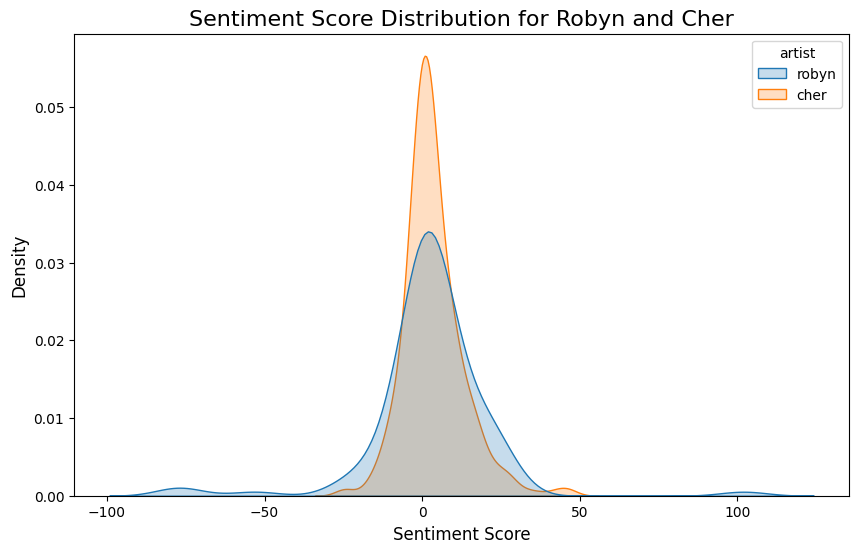

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(data=lyrics_df, x='sentiment_score', hue='artist', fill=True, common_norm=False)
plt.title('Sentiment Score Distribution for Robyn and Cher', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [30]:
# your code here

files = {
    "cher": "/Users/muriss/Downloads/M1 Results/twitter/cher_followers_data.txt",
    "robyn": "/Users/muriss/Downloads/M1 Results/twitter/robynkonichiwa_followers_data.txt"
}

followers_data = []

for artist, file_path in files.items():
    df = pd.read_csv(file_path, sep='\t', engine='python', on_bad_lines='skip')
    df['artist'] = artist
    followers_data.append(df)

followers_df = pd.concat(followers_data, ignore_index=True)

In [31]:

positive_emojis = ['😀', '😊', '😃', '😍', '😎', '😁', '🥳', '🎉', '👍', '❤️']
negative_emojis = ['😡', '😢', '😠', '😞', '💔', '😭', '🤬', '👎', '😤', '😓']

emoji_sentiment_dict = {em: 1 for em in positive_emojis}
emoji_sentiment_dict.update({em: -1 for em in negative_emojis})

def calculate_emoji_sentiment(description, emoji_dict):
    score = 0
    for char in description:
        if char in emoji_dict:
            score += emoji_dict[char]
    return score

followers_df['emoji_sentiment'] = followers_df['description'].fillna('').apply(lambda desc: calculate_emoji_sentiment(desc, emoji_sentiment_dict))
average_emoji_sentiment = followers_df.groupby('artist')['emoji_sentiment'].mean()

print("\nAverage Emoji Sentiment:")
print(average_emoji_sentiment)


Average Emoji Sentiment:
artist
cher     0.006012
robyn    0.002886
Name: emoji_sentiment, dtype: float64


Q: What is the average sentiment of your two artists? 

```
Average Emoji Sentiment for Each Artist:
artist
cher     0.006012
robyn    0.002886
```
---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 


In [33]:
positive_emojis = ['😀', '😊', '😃', '😍', '😎', '😁', '🥳', '🎉', '👍', '❤️']
negative_emojis = ['😡', '😢', '😠', '😞', '💔', '😭', '🤬', '👎', '😤', '😓']

files = {
    "cher": "/Users/muriss/Downloads/M1 Results/twitter/cher_followers_data.txt",
    "robyn": "/Users/muriss/Downloads/M1 Results/twitter/robynkonichiwa_followers_data.txt"
}

followers_data = []

for artist, file_path in files.items():
    df = pd.read_csv(file_path, sep='\t', engine='python', on_bad_lines='skip')
    df['artist'] = artist
    followers_data.append(df)

followers_df = pd.concat(followers_data, ignore_index=True)

def count_emoji_occurrences(description, emoji_list):
    occurrences = {em: 0 for em in emoji_list}
    for char in description:
        if char in emoji_list:
            occurrences[char] += 1
    return occurrences

positive_emoji_counts_cher = {em: 0 for em in positive_emojis}
positive_emoji_counts_robyn = {em: 0 for em in positive_emojis}
negative_emoji_counts_cher = {em: 0 for em in negative_emojis}
negative_emoji_counts_robyn = {em: 0 for em in negative_emojis}

for index, row in followers_df.iterrows():
    artist = row['artist']
    description = row['description'] if pd.notnull(row['description']) else ""
    positive_counts = count_emoji_occurrences(description, positive_emojis)
    negative_counts = count_emoji_occurrences(description, negative_emojis)
    
    if artist == 'cher':
        for emoji_char, count in positive_counts.items():
            positive_emoji_counts_cher[emoji_char] += count
        for emoji_char, count in negative_counts.items():
            negative_emoji_counts_cher[emoji_char] += count
    elif artist == 'robyn':
        for emoji_char, count in positive_counts.items():
            positive_emoji_counts_robyn[emoji_char] += count
        for emoji_char, count in negative_counts.items():
            negative_emoji_counts_robyn[emoji_char] += count

most_popular_positive_cher = max(positive_emoji_counts_cher, key=positive_emoji_counts_cher.get)
most_popular_negative_cher = max(negative_emoji_counts_cher, key=negative_emoji_counts_cher.get)
most_popular_positive_robyn = max(positive_emoji_counts_robyn, key=positive_emoji_counts_robyn.get)
most_popular_negative_robyn = max(negative_emoji_counts_robyn, key=negative_emoji_counts_robyn.get)

most_popular_positive_cher, 
most_popular_negative_cher, 
most_popular_positive_robyn, 
most_popular_negative_robyn



('😍', '💔', '😎', '💔')